## Setup

In [1]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import os
import urllib.request as urlreq

import torch
import os
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import datasets, transforms, models

## Loading Dataset

In [21]:
val_dir = 'images/validation'
train_dir = 'images/train'
test_dir = 'images/test'

from torchvision import datasets, transforms, models

batch = 4

transformer = transforms.Compose([transforms.ToTensor(),])

train_data = datasets.ImageFolder(train_dir,       
                transform=transformer)
test_data = datasets.ImageFolder(test_dir,
                transform=transformer)
validation_data = datasets.ImageFolder(val_dir,
                transform=transformer)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch)
testloader = torch.utils.data.DataLoader(validation_data, batch_size=batch)

# def load_split_train_test(datadir, valid_size = .2):
#     train_transforms = transforms.Compose([
#                                        transforms.ToTensor(),
#                                        ])
#     test_transforms = transforms.Compose([
#                                       transforms.ToTensor(),
#                                       ])
#     train_data = datasets.ImageFolder(datadir,       
#                     transform=train_transforms)
#     test_data = datasets.ImageFolder(datadir,
#                     transform=test_transforms)
#     num_train = len(train_data)
#     indices = list(range(num_train))
#     split = int(np.floor(valid_size * num_train))
#     np.random.shuffle(indices)
#     from torch.utils.data.sampler import SubsetRandomSampler
#     train_idx, test_idx = indices[split:], indices[:split]
#     train_sampler = SubsetRandomSampler(train_idx)
#     test_sampler = SubsetRandomSampler(test_idx)
#     trainloader = torch.utils.data.DataLoader(train_data,
#                    sampler=train_sampler, batch_size=4)
#     testloader = torch.utils.data.DataLoader(test_data,
#                    sampler=test_sampler, batch_size=4)
#     return trainloader, testloader

#trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Model Stuff

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)

In [23]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
epochs = 2
steps = 0
running_loss = 0
print_every = 500
train_losses, test_losses = [], []
test_loss = accuracy = 0
print("\nTest loss: " + str(test_loss/len(testloader)) +
      "\nTest accuracy: " + str(accuracy/len(testloader)))
for epoch in range(epochs):
    for inputs, labels in tqdm(trainloader):
        #print(inputs.shape)
        #print(steps)
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in tqdm(testloader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))                    
                print("Train loss: " + str(running_loss) +
                      "\nTest loss: " + str(test_loss/len(testloader)) +
                      "\nTest accuracy: " + str(accuracy/len(testloader)))
                running_loss = 0
                model.train()
        
    
torch.save(model, 'aerialmodel.pth')


Test loss: 0.0
Test accuracy: 0.0


 14%|█████▏                               | 501/3606 [03:59<30:28:32, 35.33s/it]

Train loss: 0.0
Test loss: 45019.4886106395
Test accuracy: 0.13582342954159593


 28%|█████████▉                          | 1000/3606 [08:21<43:46:18, 60.47s/it]

Train loss: 118367.09675007313
Test loss: 12685.183465531267
Test accuracy: 0.144029428409734


 42%|█████████████▎                  | 1500/3606 [7:09:38<471:44:39, 806.40s/it]

Train loss: 25862.488469507545
Test loss: 10950.13057779119
Test accuracy: 0.2582059988681381


 55%|██████████████████▎              | 2000/3606 [7:21:01<68:51:14, 154.34s/it]

Train loss: 18450.58387169987
Test loss: 14685.768821901971
Test accuracy: 0.17204301075268819


 69%|██████████████████████▉          | 2500/3606 [7:33:59<55:53:47, 181.94s/it]

Train loss: 0.24764090031385422
Test loss: 24894.76744216893
Test accuracy: 0.17204301075268819


 83%|███████████████████████████▍     | 3000/3606 [7:45:12<25:12:21, 149.74s/it]

Train loss: 36629.92895806022
Test loss: 20975.69497039916
Test accuracy: 0.16114883984153933


 97%|█████████████████████████████████ | 3500/3606 [7:56:24<4:27:25, 151.37s/it]

Train loss: 52613.31849497091
Test loss: 5217.739066106152
Test accuracy: 0.11304470854555744


 11%|███▊                               | 394/3606 [10:18<131:48:52, 147.74s/it]

Train loss: 7641.087892152835
Test loss: 12537.169830684954
Test accuracy: 0.13582342954159593


 25%|███████▋                       | 894/3606 [1:28:28<1023:16:42, 1358.33s/it]

Train loss: 32022.788028165465
Test loss: 6.993864140560535
Test accuracy: 0.144029428409734


 39%|████████████▊                    | 1394/3606 [1:39:35<93:31:48, 152.22s/it]

Train loss: 101.19047105498612
Test loss: 6.047042726662409
Test accuracy: 0.2582059988681381


 53%|█████████████████▎               | 1894/3606 [1:50:55<73:09:28, 153.84s/it]

Train loss: 0.2507881498313509
Test loss: 4072.0091212153366
Test accuracy: 0.2582059988681381


 66%|█████████████████████▉           | 2394/3606 [2:02:14<51:52:46, 154.10s/it]

Train loss: 8888.499248443928
Test loss: 6.597698982895142
Test accuracy: 0.17204301075268819


 80%|██████████████████████████▍      | 2894/3606 [2:13:46<30:57:35, 156.54s/it]

Train loss: 106.4878182336688
Test loss: 6.545165408668849
Test accuracy: 0.16114883984153933


 94%|████████████████████████████████  | 3394/3606 [2:25:16<9:15:13, 157.14s/it]

Train loss: 108.51741423027124
Test loss: 6.812258974897127
Test accuracy: 0.11304470854555744


100%|█████████████████████████████████████| 3606/3606 [2:26:32<00:00,  2.44s/it]


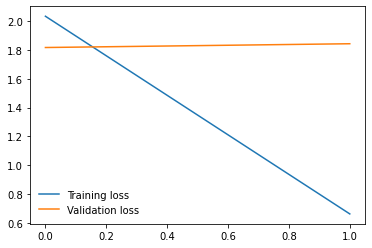

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [16]:
def predict_image(image):
    test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      ])
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [17]:
def get_random_images(num):
    test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      ])
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

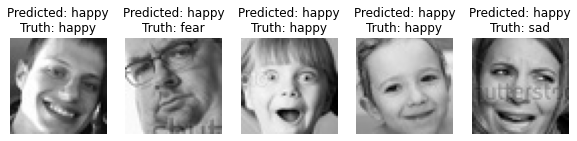

In [18]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
classes = trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    #print(index)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    #print(labels[ii])
    sub.set_title("Predicted: " + str(classes[index]) + "\nTruth: " + classes[int(labels[ii])])
    plt.axis('off')
    plt.imshow(image)
plt.show()

## Facial Landmark Detector

In [ ]:
def get_landmarks(img_name):
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    #img = cv2.imread(img_name)
    # save face detection algorithm's url in haarcascade_url variable
    haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"

    # save face detection algorithm's name as haarcascade
    haarcascade = "haarcascade_frontalface_alt2.xml"

    # chech if file is in working directory
    if (haarcascade not in os.listdir(os.curdir)):
        # download file from url and save locally as haarcascade_frontalface_alt2.xml, < 1MB
        urlreq.urlretrieve(haarcascade_url, haarcascade)
        print("File downloaded")

    # create an instance of the Face Detection Cascade Classifier
    detector = cv2.CascadeClassifier(haarcascade)

    # Detect faces using the haarcascade classifier on the "grayscale image"
    faces = detector.detectMultiScale(img)

    if len(faces) == 0:
        faces = np.array([[0,0,48,48]])
        
    img = cv2.imread(img_name)
    LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"

    # save facial landmark detection model's name as LBFmodel
    LBFmodel = "lbfmodel.yaml"

    # check if file is in working directory
    if (LBFmodel not in os.listdir(os.curdir)):
        # download picture from url and save locally as lbfmodel.yaml, < 54MB
        urlreq.urlretrieve(LBFmodel_url, LBFmodel)
        print("File downloaded")

    # create an instance of the Facial landmark Detector with the model
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)

    # Detect landmarks on "image_gray"
    _, landmarks = landmark_detector.fit(img, faces)

    for landmark in landmarks:
        for x,y in landmark[0]:
            # display landmarks on "image_cropped"
            # with white colour in BGR and thickness 1
            cv2.circle(img, (int(x), int(y)), 0, (255, 0, 0), 1)
    plt.axis("off")
    plt.imshow(img)
    
    return landmarks


In [ ]:
data = get_landmarks(validationSet[0])

## Model